### Introduction

In this notebook, we will learn how to design a quantum circuit in Qiskit for a given Hamiltonian and run the circuit on the IBM's Quantum Computer and quantum simulator. [Qiskit](https://qiskit.org/) is a python library developed by IBM for designing quantum circuits and interfacing with their quantum computer over the cloud.

You can get started right away by creating an [IBM Q Experience](https://quantum-computing.ibm.com/login) account.

The Hamiltonian we will use for our example is for a one-dimensional Ising spin chain in an external transverse magnetic field:

$$H(t) = -J_z \sum_{i=1}^{N-1} \sigma_{i}^z \sigma_{i+1}^z - \epsilon_{ph}cos(\omega_{ph}t) \sum_{i=1}^{N} \sigma_{i}^x$$

In order to simulate the evolution of the qubits under this Hamitonian, we must apply the time-evolution operator $U(t)$ to the qubits.

$$U(t) = Texp\{-\frac{i}{\hbar}\int_{0}^{t}H(t)dt\}$$

Since exponentiation of the Hamiltonian is difficult, two approximations are made:
(1) The time-dependence of $H(t)$ must be ignored on time scales smaller than some chosen, minimal time-step $\Delta t$.  The Hamiltonian can then be approximated as a piece-wise constant function that takes the constant value $H((j+\frac{1}{2})\Delta t)$ during the time interval $[j \Delta t, (j+1) \Delta t]$, where $j$ is some integer.
(2) Each matrix exponential must be approximated with the Trotter decomposition.  To perform the Trotter decomposition, the Hamiltonian must be divided into components that are each efficiently diagonalizable on their own

$$H(t) = H_x(t) = H_z $$ where 
$$H_z = -J_z \sum_{i=1}^{N-1} \sigma_{i}^z \sigma_{i+1}^z$$ 
$$H_x = \epsilon_{ph}cos(\omega_{ph}t) \sum_{i=1}^{N} \sigma_{i}^x$$

Thus, the time evolution operator is finally approximated as
$$U(n \Delta t) = \prod_{j=0}^{n-1} e^{-iH_{x}((j+ \frac{1}{2})\Delta t)\Delta t} e^{-iH_{z}\Delta t}$$

This circuit can be defined with the following function written in Qiskit:

In [5]:
#import necessary libraries
import numpy as np
import qiskit as qk
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram, plot_gate_map, plot_circuit_layout

from qiskit import Aer, IBMQ, execute
from qiskit.providers.aer import noise

import matplotlib.pyplot as plt
%matplotlib inline 

#define physical parameters
H_BAR = 0.658212    # eV*fs
JZ = 0.01183898    # eV, coupling coeff; Jz<0 is antiferromagenetic, Jz>0 is ferromagnetic
FREQ = 0.0048       # 1/fs, frequency of MoSe2 phonon

## Parameters
delta_t = 3      # fs
total_t = 60     # fs
num_steps = int(total_t / delta_t)

shots = 1024
num_qubits = 2

w_ph = 2 * np.pi * FREQ
jz_factor = [1.0] #, 0.2, 0.5, 1.0, 5.0]

def evolution_circuit(qr, cr, delta_t, total_time, w_ph, e_ph, circ_name=None):
    """
    Define circuit for evolution of wavefunction, i.e.,
    H(t) = - Jz * sum_{i=1}^{N-1}(sigma_{z}^{i} * sigma_{z}^{i+1})
           - e_ph * cos(w_ph * t) * sum_{i=1}^{N}(sigma_{x}^{i})

    Args:
    - qr: quantum registers.
    - cr: classical registers.
    - delta_t: unit of propagation time in attoseconds.
    - total_time: systems's total propagation time in attoseconds.
    - w_ph: frequency of E" phonon in MoSe2.
    - e_ph: strength of electron-phonon coupling.
    - circ_name (str): name of the circuit to be created.
    
    Returns:
    - A quantum circuit representating the propagation of the system.
    """
    
    num_qubits = qr.size    
    prop_steps = int(total_time / delta_t)  # number of propagation steps
    
    # Instantiate quantum circuit for the propagator to which
    #-we add terms of Hamiltonian piece by piece
    circuit = qk.QuantumCircuit(qr, cr)
    if circ_name:
        circuit.name = circ_name

    for step in range(prop_steps):
        t = (step + 0.5) * delta_t
        prop_circ = qk.QuantumCircuit(qr)
        
        # TODO: need comments for codeblock below?
        psi = -2.0 * e_ph * np.cos(w_ph * t) * delta_t / H_BAR
        prop_circ.h(qr)
        prop_circ.rz(psi, qr)
        prop_circ.h(qr)
    
        # Coupling terms
        psi2 = -2.0 * JZ * delta_t / H_BAR
        for i in range(num_qubits-1):
            prop_circ.cx(qr[i], qr[i+1])
            prop_circ.rz(psi2, qr[i+1])
            prop_circ.cx(qr[i], qr[i+1])
            
        # Concatenate circuites
        circuit += prop_circ
        #circuit.barrier(qr)

    # Add measurement operation
    circuit.measure(qr, cr)
#    print(circuit)
    return circuit

### Get backend

In order to run our code on the quantum processor or simulator, you will need to connect with IBM's server.  To do so, you will need you API_Token, which you can find by logging in to your IBM Q Experience account under "My Account".

The first time you run this notebook, you should run the save_account function with your token as the argument. This will since it will save your account in '~/.qiskit/qiskitrc', so all future times running this notebook you will only need to load your account with the load_account function.  You can delete this file if you need to regenerate a token with delete_account.

In [6]:
#qk.IBMQ.save_account('here') ## only run once!
#qk.IBMQ.delete_accounts() ## only run if you need to use a new token
qk.IBMQ.load_account()

/anaconda3/lib/python3.7/site-packages/qiskit/providers/ibmq/ibmqfactory.py:181: UserWarning: Credentials are already in use. The existing account in the session will be replaced.
  warnings.warn('Credentials are already in use. The existing '


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

Next, you'll want to check which backends (quantum processors) your account has access to:

In [7]:
#choose the device you would like to run on
device = provider.get_backend('ibmq_ourense')

In [8]:
## Show available backends
provider = qk.IBMQ.get_provider(group='open')
provider.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_vigo') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_ourense') from IBMQ(hub='ibm-q', group='open', project='main')>]

If you plan to run your code on the simulator, you may wish to gather fidelity statistics of a specific device so that you can create a noise model for the simulator to use which mimics a chosen device.  The code below shows how to gather the properties of a certain device, create the noise model, and set up the simulator as your backend

In [9]:
#gather fidelity statistics on this device if you want to create a noise model for the simulator
device = provider.get_backend('ibmq_ourense')
properties = device.properties()
coupling_map = device.configuration().coupling_map

#TO RUN ON THE SIMULATOR 
#create a noise model to use for the qubits of the simulator
noise_model = noise.device.basic_device_noise_model(properties)
# Get the basis gates for the noise model
basis_gates = noise_model.basis_gates

# Select the QasmSimulator from the Aer provider
simulator = Aer.get_backend('qasm_simulator')

Alternatively, you can run your code on a quantum processor.  To do this, you must choose a specific machine as your backend to run your code on by name.

In [10]:
#To run on the quantum computer, assign a quantum computer of your choice as the backend 
backend = provider.get_backend('ibmq_ourense')

### Build circuits & map qubits
The next step is the create the physical quantum circuit to run on the quantum processor or simulator.  This involves creating a list of native gates that will sequentially act on the qubits, as well as mapping the logical qubits in the code to the physical qubits of the specific device that was chosen as your backend.

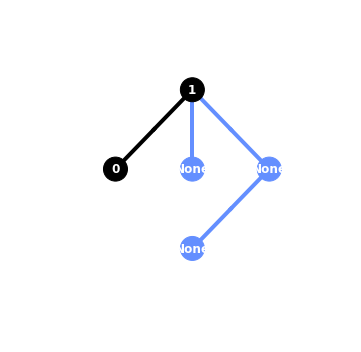

In [11]:
## Declare registers
q_regs = qk.QuantumRegister(num_qubits, 'q')
c_regs = qk.ClassicalRegister(num_qubits, 'c')

## Create circuit
circuits = []
for factor in jz_factor:
    e_ph = factor * JZ
    
    for j in range(0, num_steps+1):
        evolution_time = delta_t * j
        name = 'circuit_eph_{}_time_{}'.format(factor, evolution_time)
        circuits.append(evolution_circuit(q_regs, c_regs, delta_t, evolution_time, w_ph, e_ph, name))

## specify qubit mapping
circ = qk.transpile(circuits, backend=backend, optimization_level=3)
#circ = qk.transpile(circuits, backend=backend, initial_layout=[3,4])

## plot mapping
plot_circuit_layout(circ[0], backend)

### Run job
Now that a circuit has been created, we can run it on our chosen backend. Note that if your job infomation can be found at: https://quantum-computing.ibm.com/

In [ ]:
#CHOOSE TO RUN ON QUANTUM COMPUTER OR SIMULATOR

#quantum computer execution
job = qk.execute(circ, backend=backend, shots=shots)
job_monitor(job)

#simulator execution
result_noise = execute(circ, simulator, noise_model=noise_model,coupling_map=coupling_map,basis_gates=basis_gates).result()

Job Status: job is queued (1)       

### Post processing
Finally we can run some post-processing code to transform the raw results of 0's and 1's from qubit measurment.  In our case we hope to measure the average magnetization, which simply involves mapping the 0's to a magnetization of 1 and the 1's to a magnetization of -1 and averaging over all qubits.

**Define functions for post-processing**

In [31]:
import numpy as np
import os
import csv


def post_pocessing(infile, outfile):
  favg = open('averages.txt', 'w')
  with open('test.npy', 'rb') as f:
    trails, nqubits, num_steps, len_ephs = np.load(f)
    for i in range(1, num_steps):
      results = []
      for j in range(len_ephs):
        bitstrings = np.load(f)
        for t in range(0, trails):
          for q in range(0, nqubits):
            if bitstrings[t][q] == 0:
              bitstrings[t][q] = 1.0
            else:
              bitstrings[t][q] = -1.0
        results.append(np.mean([bitstrings[:,0]]))
      for e in range(0, len_ephs):
        favg.write(str(results[e]))
        favg.write('\t')
      favg.write('\n')
  favg.close()
  print("Created file: {}".format(outfile))


def npy_to_txt(npyfile, txtfile):
  ftxt = open(txtfile, 'w')
  with open(npyfile, 'rb') as f:
    _, _, num_steps, len_ephs = np.load(f)
    for _ in range(1, num_steps):
      for _ in range(len_ephs):
        bitstrings = np.load(f)
        np.savetxt(ftxt, bitstrings, fmt='%d')
        ftxt.write('\n')
      ftxt.write('\n')
  ftxt.close()
  print("Created file: {}".format(txtfile))


def average_magnetization(result: dict, shots: int):
  """Compute average magnetization from results of qk.execution.
  Args:
  - result (dict): a dictionary with the counts for each qubit, see qk.result.result module
  - shots (int): number of trials
  Return:
  - average_mag (float)
  """
  mag = 0
  for spin_str, count in result.items():
    spin_int = [1 - 2 * float(s) for s in spin_str]
    mag += (sum(spin_int) / len(spin_int)) * count
  average_mag = mag / shots
  return average_mag

In [32]:
#QUANTUM COMPUTER POST PROCESSING
results = job.result()        

avg_mag_qc = []
temp = []
i = 1
for c in circ:
    result_dict = results.get_counts(c)
    temp.append(average_magnetization(result_dict, shots))
    if i % num_steps == 0:
        avg_mag_qc.append(temp)
        temp = []
    i += 1

In [33]:
#SIMULATOR POST PROCESSING
avg_mag_sim = []
temp = []
i = 1
for c in circ:
    result_dict = result_noise.get_counts(c)
    temp.append(average_magnetization(result_dict, shots))
    if i % num_steps == 0:
        avg_mag_sim.append(temp)
        temp = []
    i += 1

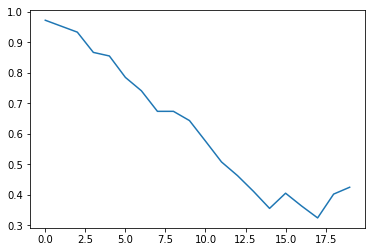

In [36]:
# QC
plt.plot(range(num_steps), avg_mag_qc[0])
plt.show()

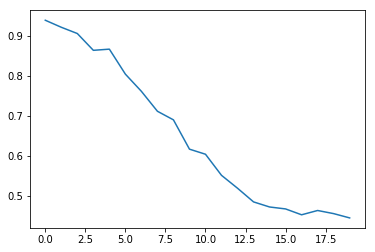

In [37]:
# simulator
plt.plot(range(num_steps), avg_mag_sim[0])
plt.show()